# Forecasting Demand

In this example, we will be forecasting the demand of a product for a given week.  The data used is the public dataset: [Product Demand Data](https://www.kaggle.com/felixzhao/productdemandforecasting).


We will be using Sparkling Water to demonstrate how to add time lags on large data.

Our Machine Learning Workflow is: 

1. Exploratory Analysis - explore and analyze the dataset
2. Baseline Model - train a random forest model with default parameters on the data
    * how predictive is our model?
    * what variables are important?
3. Feature Engineering - add new features that we think could help improve the results
    * date expansion
    * time lags
4. Model Training - train a random forest with default parameters on the extended data
    * how predictive is our model compared with the model trained on our raw data?
    * what variables are important?
5. Residual Analysis
    * where are our predictions good?  
    * where are they bad?

## Exploratory Analysis

We begin by starting our sparkling water cluster and importing our dataset into H2O.

In [1]:
#Initiate H2OContext on top of Spark
from pysparkling import *
import h2o
hc = H2OContext.getOrCreate(spark)

PySparkling is using internally bundled H2O of version 3.22.0.4, but H2O installed in the python environment is of version 3.22.1.1.


Connecting to H2O server at http://172.16.2.123:54321... successful.


H2O cluster uptime:,07 secs
H2O cluster timezone:,America/Los_Angeles
H2O data parsing timezone:,UTC
H2O cluster version:,3.22.0.4
H2O cluster version age:,10 days
H2O cluster name:,sparkling-water-megankurka_local-1547594971476
H2O cluster total nodes:,1
H2O cluster free memory:,853 Mb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"accepting new members, healthy"



Sparkling Water Context:
 * H2O name: sparkling-water-megankurka_local-1547594971476
 * cluster size: 1
 * list of used nodes:
  (executorId, host, port)
  ------------------------
  (driver,megans-mbp-1343.0xdata.loc,54321)
  ------------------------

  Open H2O Flow in browser: http://172.16.2.123:54321 (CMD + click in Mac OSX)

    


In [2]:
# Import data
demand_data = h2o.import_file("./Historical Product Demand.csv")

Parse progress: |█████████████████████████████████████████████████████████| 100%


Our data consists of the total quantity order for a particular product and warehouse on a given date.  Our goal for this demo will be to forecast demand for next month.

In [3]:
demand_data.head()

Product_Code,Warehouse,Product_Category,Date,Order_Demand
Product_0993,Whse_J,Category_028,2012/7/27,100
Product_0979,Whse_J,Category_028,2012/1/19,500
Product_0979,Whse_J,Category_028,2012/2/3,500
Product_0979,Whse_J,Category_028,2012/2/9,500
Product_0979,Whse_J,Category_028,2012/3/2,500
Product_0979,Whse_J,Category_028,2012/4/19,500
Product_0979,Whse_J,Category_028,2012/6/5,500
Product_0979,Whse_J,Category_028,2012/6/27,500
Product_0979,Whse_J,Category_028,2012/7/23,500
Product_0979,Whse_J,Category_028,2012/8/29,500


In [4]:
demand_data.describe()

Rows:1048575
Cols:5




,Product_Code,Warehouse,Product_Category,Date,Order_Demand
type,enum,enum,enum,enum,int
mins,,,,,0.0
mean,,,,,4936.488008931645
maxs,,,,,4000000.0
sigma,,,,,29024.624091856833
zeros,,,,,28681
missing,0,0,0,0,10469
0,Product_0993,Whse_J,Category_028,2012/7/27,100.0
1,Product_0979,Whse_J,Category_028,2012/1/19,500.0
2,Product_0979,Whse_J,Category_028,2012/2/3,500.0


We will remove any NA dates and convert our `Date` column to a time column.

In [5]:
# Filter records with missing date
demand_data = demand_data[demand_data["Date"] != "NA"]

In [6]:
demand_data["Date"] = demand_data["Date"].as_date("%Y/%m/%d")

We can use H2O to get an understanding of our data.  We see that we have 6 years of data and most of the orders have demand between 0 and 1 million.

In [7]:
print("Time Range: " + str(int(demand_data["Date"].year().min())) + " to " + str(int(demand_data["Date"].year().max())))

Time Range: 2011 to 2017


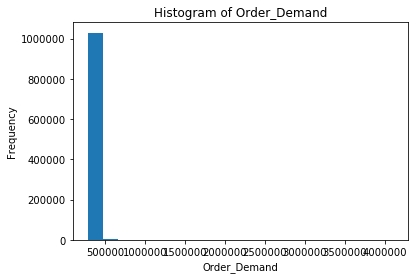

In [8]:
demand_data["Order_Demand"].hist()

## Frame Data for Forecasting

Our goal is to use this historical data to forecast the demand. The way in which we format the data for forecasting is completely dependent on what we want to do with this forecast.

To format the data for forecasting, we need to aggregate our data for each group we are interested in and for a specific time period.

Our use case is to: *forecast the total demand for a product and warehouse next month*

For this use case, we need to aggregate our data by Product, Warehouse, and Date.

In [9]:
demand_data["Month"] = demand_data["Date"].month()
demand_data["Year"] = demand_data["Date"].year()

In [10]:
group_cols = ["Product_Code", "Warehouse", "Product_Category", "Year", "Month"]
agg_demand_data = demand_data.group_by(group_cols).sum("Order_Demand").min("Date")
agg_demand_data = agg_demand_data.get_frame()

In [11]:
agg_demand_data.head()

Product_Code,Warehouse,Product_Category,Year,Month,sum_Order_Demand,min_Date
Product_0001,Whse_A,Category_005,2012,1,6400,1.32555e+12
Product_0001,Whse_A,Category_005,2012,2,10400,1.32849e+12
Product_0001,Whse_A,Category_005,2012,3,11000,1.33116e+12
Product_0001,Whse_A,Category_005,2012,4,1500,1.33393e+12
Product_0001,Whse_A,Category_005,2012,5,8000,1.33583e+12
Product_0001,Whse_A,Category_005,2012,6,2000,1.33851e+12
Product_0001,Whse_A,Category_005,2012,7,8000,1.34119e+12
Product_0001,Whse_A,Category_005,2012,8,6400,1.34395e+12
Product_0001,Whse_A,Category_005,2012,9,5600,1.34663e+12
Product_0001,Whse_A,Category_005,2012,10,nan,1.34905e+12


## Baseline Model Training

We will start by traininig a random forest model using raw features.  This will be our baseline model. We will use it to see which variables are important to the model.  We can also use it to see if any features we add in the future improve our model.

In [12]:
# Set Predictors and Response
response = "sum_Order_Demand"
predictors = list(set(agg_demand_data.col_names) - set([response]))

In [13]:
# Split data into training and testing by time

# Testing data is data from the year 2016

train = agg_demand_data[agg_demand_data["Year"] < 2016]
test = agg_demand_data[agg_demand_data["Year"] >= 2016]

In [14]:
# Train Random Forest
from h2o.estimators import H2ORandomForestEstimator

drf_baseline = H2ORandomForestEstimator(model_id = "drf_baseline.hex",
                                        seed = 1234 # Random Seed
                                       )
drf_baseline.train(x = predictors, y = response, training_frame = train, validation_frame = test)

drf Model Build progress: |███████████████████████████████████████████████| 100%


There are many ways we can evaluate our model.  Some of the most common metrics are Mean Absolute Error and Root Mean Squared Error.

The mean absolute error tells us that on average we are off in our prediction by 22,834 units.

In [15]:
print("Mean Absolute Error on Test: " + "{:,.0f}".format(drf_baseline.mae(valid = True)))
print("Root Mean Squared Error on Test: " + "{:,.0f}".format(drf_baseline.rmse(valid = True)))

Mean Absolute Error on Test: 22,834
Root Mean Squared Error on Test: 146,886


Both metrics are better when they are smaller, however, RMSE gives a high weight to large errors.  RMSE should be used when large errors are very bad.  If you do not care if you have the occasional large error if most of your predictions are pretty good, then you should use MAE.  For a more detailed comparison: https://medium.com/human-in-a-machine-world/mae-and-rmse-which-metric-is-better-e60ac3bde13d.

It is hard to tell if these errors are good or bad.  If I am off by about 22.8k units on average is that pretty close? 

One way to understand how good the error is is by calculating the average percent error.  This is what percentage off are we from the actual demand. We define the following functions to calculate the percent error metrics.

In [16]:
def MAPE(model, test, actualCol):
    pred = model.predict(test)
    percent_error = (test[actualCol] - pred)/test[actualCol]
    
    return percent_error.abs().mean()[0]

def RMSPE(model, test, actualCol):
    pred = model.predict(test)
    percent_error = (test[actualCol] - pred)/test[actualCol]
    
    return (percent_error**2).mean()[0]**0.5

The Mean Absolute Percent Error shows us that on average we are off by 4,166% so our model is doing very poorly.

In [17]:
mape = MAPE(drf_baseline, test, "sum_Order_Demand")
rmspe = RMSPE(drf_baseline, test, "sum_Order_Demand")

print("Mean Absolute Percent Error: " + "{:,.0f}%".format(mape*100))
print("Root Mean Squared Percent Error: " + "{:,.0f}%".format(rmspe*100))

drf prediction progress: |████████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%
Mean Absolute Percent Error: 4,166%
Root Mean Squared Percent Error: 44,148%


The graph below shows the variable importance for the random forest model.  The most important predictors are `Product_Code`, `Warehouse`, and `Product_Category`.  We can use the partial dependence plots to see the relationship between these features and the model's prediction. (We will not show the partial plot for `Product_Code` because there are over 2,000 different products in the dataset).

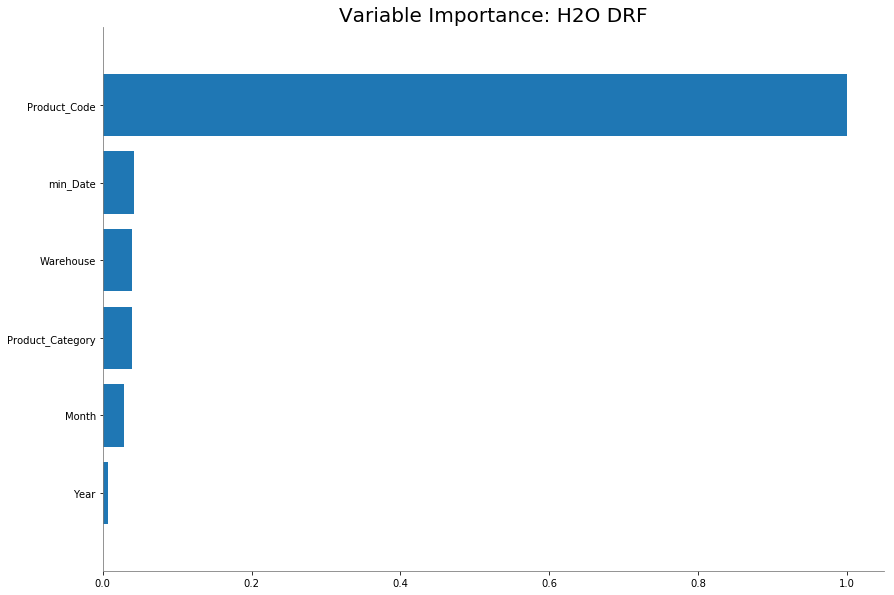

In [18]:
drf_baseline.varimp_plot()

PartialDependencePlot progress: |█████████████████████████████████████████| 100%


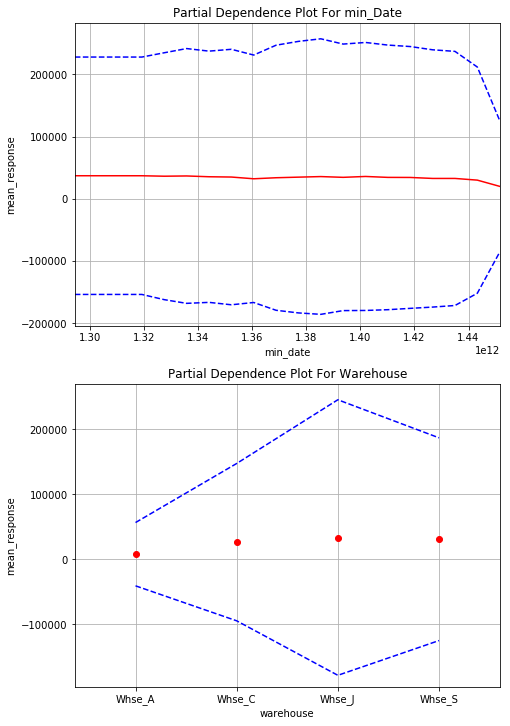

In [19]:
# Partial Dependence Plots of `min_Date` and `Warehouse`

%matplotlib inline

pdps = drf_baseline.partial_plot(data = train, cols = ["min_Date", "Warehouse"])

From the partial dependence plots we can see that the demand has been decreasing slightly overtime.  It also looks like `Whse_J` has the greatest demand.

## Feature Engineering

We will now add new features to our model to see if we can improve our accuracy.  We will want to add historical features.  What was the demand last month for this product?  What was the demand two months ago?  

To create these features we will use PySpark's window function.

In [20]:
## Convert H2O Frame to Spark DataFrame
demand_df = hc.as_spark_frame(agg_demand_data)

In [21]:
## Add Demand the Previous Day, Previous 2 days, Previous 3 days, and Previous week per Product and Warehouse
from pyspark.sql.functions import lag, col
from pyspark.sql.window import Window

w = Window().partitionBy(col("Product_Code"), col("Product_Category"), col("Warehouse")).orderBy(col("min_Date"))
ext_demand_df = demand_df.select("*", lag("sum_Order_Demand", count = 1).over(w).alias("Demand_lag1"),
                                 lag("sum_Order_Demand", count = 2).over(w).alias("Demand_lag2"),
                                 lag("sum_Order_Demand", count = 3).over(w).alias("Demand_lag3"),
                                 lag("sum_Order_Demand", count = 12).over(w).alias("Demand_lag12")).na.drop()

In [22]:
## Convert Spark DataFrame to H2O Frame

ext_demand_hf = hc.as_h2o_frame(ext_demand_df, "demandWithLagsTable")

In [23]:
## Convert strings to categoricals
## This step always needs to be done when converting from Spark DataFrame to H2OFrame
cat_cols = ["Product_Code", "Warehouse", "Product_Category"]
for i in cat_cols:
    ext_demand_hf[i] = ext_demand_hf[i].asfactor()
ext_demand_hf.describe()

Rows:85559
Cols:11




,Product_Code,Warehouse,Product_Category,Year,Month,sum_Order_Demand,min_Date,Demand_lag1,Demand_lag2,Demand_lag3,Demand_lag12
type,enum,enum,enum,int,int,int,int,int,int,int,int
mins,,,,2012.0,1.0,0.0,1349136000000.0,0.0,0.0,0.0,0.0
mean,,,,2014.5964539089985,6.6857256396171065,33429.78085297865,1422852704384.1091,33444.95304994214,33465.15409249758,33341.43853948737,33183.64728433011
maxs,,,,2017.0,12.0,10127000.0,1483920000000.0,10450000.0,10127000.0,10450000.0,10450000.0
sigma,,,,1.0911162432159618,3.4509795874091944,205334.63827271256,35221774777.69445,204868.32129561927,206479.01294396666,204784.09799135075,209207.85054750176
zeros,,,,0,0,48,0,53,54,53,56
missing,0,0,0,0,0,0,0,0,0,0,0
0,Product_0051,Whse_J,Category_005,2013.0,1.0,2000.0,1357776000000.0,4000.0,3525.0,2000.0,2000.0
1,Product_0051,Whse_J,Category_005,2013.0,2.0,3500.0,1359676800000.0,2000.0,4000.0,3525.0,2525.0
2,Product_0051,Whse_J,Category_005,2013.0,7.0,3550.0,1373587200000.0,1025.0,1050.0,3050.0,1500.0


## Model Training

We will now train our random forest model with our added features to check if we see a performance lift.

In [24]:
# Set Predictors
ext_predictors = list(set(ext_demand_hf.col_names) - set([response]))

In [25]:
# Split data into training and testing by time

# Testing data is data from the year 2016

ext_train = ext_demand_hf[ext_demand_hf["Year"] < 2016]
ext_test = ext_demand_hf[ext_demand_hf["Year"] >= 2016]

In [26]:
# Train Random Forest
drf_features = H2ORandomForestEstimator(model_id = "drf_features.hex",
                                        seed = 1234
                                       )
drf_features.train(x = ext_predictors, y = response, 
                   training_frame = ext_train, validation_frame = ext_test)

drf Model Build progress: |███████████████████████████████████████████████| 100%


In [27]:
feature_mape = MAPE(drf_features, ext_test, "sum_Order_Demand")
feature_rmspe = RMSPE(drf_features, ext_test, "sum_Order_Demand")

print("Mean Absolute Percent Error")
print("Baseline: " + "{0:.0f}%".format(mape*100))
print("With New Features: " + "{0:.0f}%".format(feature_mape*100))

print("\nRMSE")
print("Baseline: " + "{0:.0f}%".format(rmspe*100))
print("With New Features: " + "{0:.0f}%".format(feature_rmspe*100))

drf prediction progress: |████████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%
Mean Absolute Percent Error
Baseline: 4166%
With New Features: 389%

RMSE
Baseline: 44148%
With New Features: 2154%


We can see that the our new features have reduced the Mean Absolute Percent Error drastically from 4,000% to 390%.  We have also reduced the RMSE.

The graph below shows the variable importance for the new random forest model.  The most important predictor is the demand from the month a year ago.  We can use the partial dependence plots to see the relationship between these features and the model's prediction.

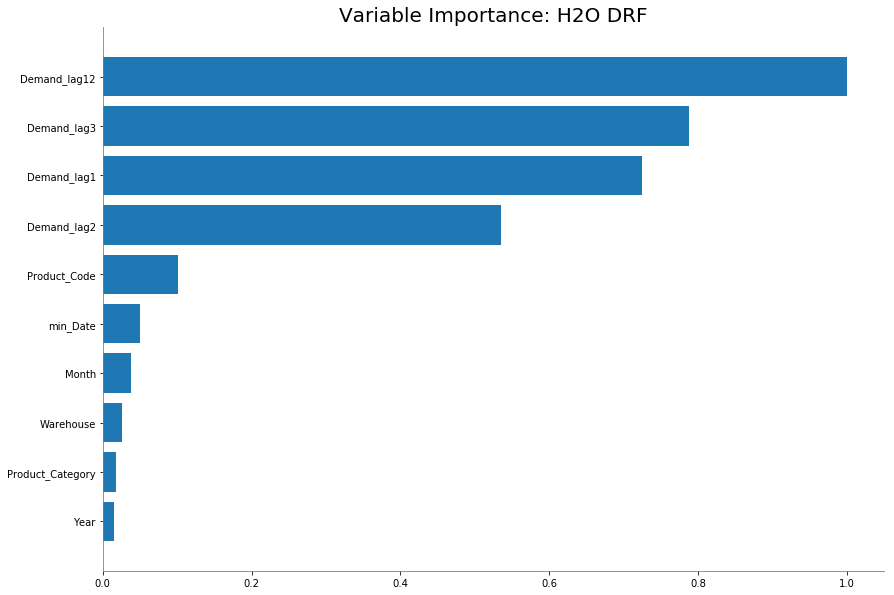

In [ ]:
drf_features.varimp_plot()

In [ ]:
pdps = drf_features.partial_plot(data = ext_train, cols = ["Demand_lag12", "Demand_lag3"])

PartialDependencePlot progress: |████████████████████████████████████

The partial plots show that the previous demands is directly correlated with the demand for next month.


## Residual Analysis

We now examine our predictions on the test data and see where we had poor predictions.

In [ ]:
# Predict on Test
test_predictions = drf_features.predict(ext_test)
# Add to Test Data
test_predictions = ext_test.cbind(test_predictions)

In [ ]:
# Calculate Error
test_predictions = test_predictions[test_predictions["sum_Order_Demand"] != 0]
test_predictions["Error"] = test_predictions["sum_Order_Demand"] - test_predictions["predict"]
test_predictions["AbsolutePercentError"] = (100*(test_predictions["Error"]/test_predictions["sum_Order_Demand"])).abs()

test_predictions[["Product_Code", "Warehouse", "Year", "Month", "sum_Order_Demand", "predict", "Error", "AbsolutePercentError"]].head()

In [ ]:
# Let's plot the residuals vs the actual

residual_pd = test_predictions[["sum_Order_Demand", "Error"]].as_data_frame()

In [ ]:
import matplotlib.pyplot as plt
# Plot Residuals vs Actual
plt.scatter(x = residual_pd["sum_Order_Demand"], y = residual_pd["Error"].abs())
plt.xlabel("sum_Order_Demand")
plt.ylabel("Absolute Error")
plt.show()

We see that we tend to have higher error when the Order Demand is very high. 